# **Introduction à l'apprentissage automatique**

Il est maintenant temps de tenter de prédire le rendement d'avoine en fonction des variables que nous avons définies. 




Nous ne traiterons pas le jeu de données comme une série chronologique.  L'année, bien que présente, sera considérée comme une caractéristique dans le jeu de données.  
Nous ne voulons pas prédire le rendement futur en nous basant sur le passé.  Nous tenterons plutôt de prédire le rendement compte tenu des caractéristiques actuelles comme 
la température et la quantité de précipitations.

## Rappel 

Pour l'apprentissage supervisé, par convention, nous utilisons deux matrices, soient $X$ et $y$. 

$X$, contient les caractéristiques (*features*) et est de taille $n \times p$, où $n$ est le nombre d'exemples (observations) et $p$ est le nombre de caractéristiques (dimensionnalité).

$$X = \begin{bmatrix} 
f_{11} & f_{12} & \ldots & f_{1p} \\
\vdots & \vdots       &  \ddots      & \vdots \\ 
f_{n1} & f_{12} & \ldots & f_{np} \\
\end{bmatrix}
$$ 

$y$, est en fait un vecteur qui contient les étiquettes associées à chaque exemple. Il est donc de taille $n$. 


$$
y = \begin{bmatrix} 
e_1 \\
e_2 \\
\vdots \\ 
e_n
\end{bmatrix}$$



$X$ et $y$ doivent toujours être ordonnés de la même façon, i.e. pour un index $i$, les données de $X_i$ correspondent à l'étiquette $y_i$.



Comme nous entrainons des modèles sur un ensemble d'entrainement (`train`) et testons leurs performances sur un ensemble de test (`test`), nous dénotons ces ensembles comme $X_\text{train}$ et $X_\text{test}$ et $Y_\text{train}$ et $Y_\text{test}$.

## Installation et chargement des librairies nécessaires

Nous devons d'abord charger (et possiblement installer) les librairies nécessaires.  

Voici une description de certaines des librairies utilisées.

- `missingo` permet de visualiser rapidement les données manquantes
- `sklearn`  scikit-learn est un incontournable pour faire de l'apprentissage automatique
- `matplotlib` et `seaborn` pour générer des graphiques
- `numpy` pour des opérations d'algèbres linéaires et mathématiques
- `pandas` pour faciliter la manipulation et la structure des données (parfois lent pour les gros jeux de données)


In [233]:
#!pip install missingno
#!pip install statsmodels
#!pip install scikit-learn 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math


import missingno
import statsmodels.api as sm


from sklearn.experimental import enable_iterative_imputer


from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import (RandomForestRegressor, RandomForestClassifier, BaggingRegressor,
                              GradientBoostingRegressor, GradientBoostingClassifier)
from sklearn.neural_network import MLPRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.datasets import make_regression

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, f1_score

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score


sns.set(font_scale=0.9, style='whitegrid')
colors = ["#40BEAD", "#248CC4", "#308E81", "#576AC9"] # IVADO palette

## Chargement des données

Nous allons utiliser les données que nous avons préparé lors de la séance de Nettoyage de données.

Le jeu données contient des données météorologiques et de rendement d'avoine collectées entre 2004 et 2022 pour un nombre de régions ontariennes.

Nous voulons prédire le rendement d'avoine.  La tâche relève donc de l'apprentissage supervisé et est une tâche de régression.  Nous voulons prédire un nombre et non une classe (étiquette).

In [2]:
df = pd.read_csv('dataset.csv', index_col=0)

De quoi a l'air la distribution de notre variable à prédire ?

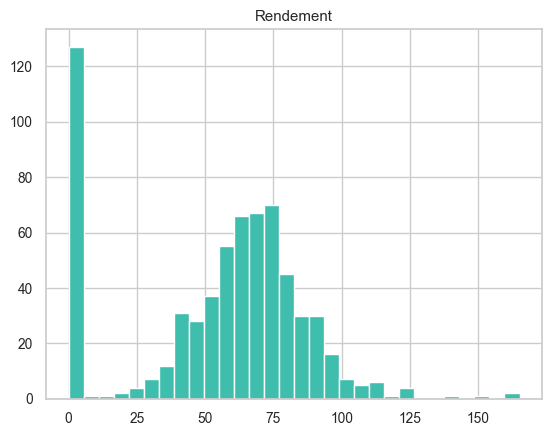

In [3]:
df.Rendement.hist(bins=30, color=colors[0])
plt.title('Rendement')
plt.show()

A-t-on des valeurs manquantes ? 

Certains algorithme d'apprentissage automatique ne supporte pas les valeurs manquantes.  Nous devons donc les imputer ou les éliminer.  Lorsque nous avons un petit nombre d'exemples, nous voulons souvent conserver le maximum d'exemples, donc l'élimination n'est pas une option envisageable.

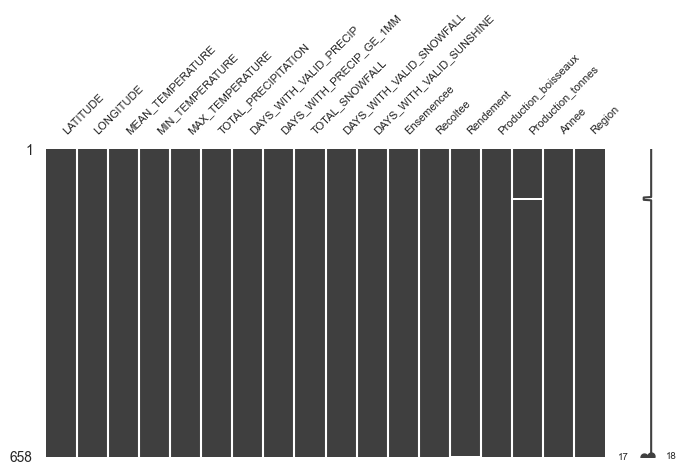

In [4]:
# Visualisons les valeurs manquantes
missingno.matrix(df, figsize=(8,4), fontsize=8)
plt.show()

Nous avons des valeurs de NaN pour la production de boisseaux en tonnes et pour certaines températures.

Le graphique de `missingo` ne représente que les NaN.  Qu'en est-il du rendement égal à  0 ?

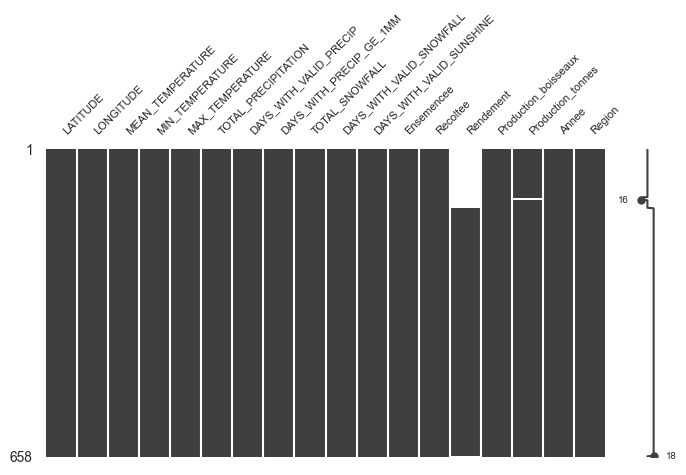

In [4]:
mx = df.copy()
mx.loc[mx.Rendement==0, 'Rendement'] = np.nan
missingno.matrix(mx, figsize=(8,4), fontsize=8)
plt.show()

Est-ce qu'une valeur de 0 lorsque nous avons une valeur de Production (boisseaux et tonnes) est un vrai 0?

In [5]:
df.loc[(df.Rendement == 0) & (df.Production_boisseaux != 0), :]

LATITUDE  LONGITUDE  MEAN_TEMPERATURE  MIN_TEMPERATURE  MAX_TEMPERATURE  \
0    45.054    -76.784          9.797829            -24.0             32.5   
0    44.403    -76.908         10.057898            -23.5             34.0   

   TOTAL_PRECIPITATION  DAYS_WITH_VALID_PRECIP  DAYS_WITH_PRECIP_GE_1MM  \
0                901.4                   352.0                    120.0   
0                815.9                   360.0                    111.0   

   TOTAL_SNOWFALL  DAYS_WITH_VALID_SNOWFALL  DAYS_WITH_VALID_SUNSHINE  \
0           168.8                     352.0                       0.0   
0           115.8                     360.0                       0.0   

    Ensemencee    Recoltee  Rendement  Production_boisseaux  \
0    27.592198   23.281722        0.0              0.796741   
0  1122.657562  947.275062        0.0             38.955752   

   Production_tonnes  Annee                Region  
0           0.016182   2021             Frontenac  
0           0.791191   2021  Lennox And Addington

In [16]:
39/947*1000

41.18268215417107

Nous n'avons que deux cas où le rendement est 0 et la production de boisseaux n'est pas 0. Est-ce une erreur?

Comme nous voulons prédire le rendement, nous ne garderons que les exemples qui ont une valeur de rendement supérieure à 0.

In [6]:
df = df.loc[df.Rendement > 0, :].reset_index()
df = df.iloc[:,1:]

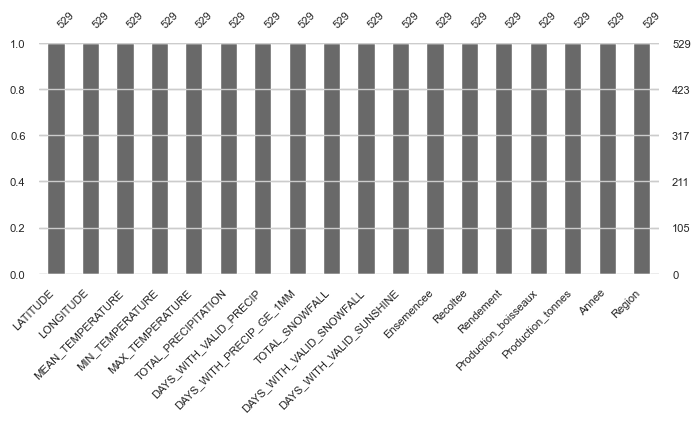

In [8]:
# Autre façon de visualiser les données manquantes.
missingno.bar(df, figsize=(8,3), fontsize=8)
plt.show()

In [7]:
# Nombre de données manquantes par variable
df.isna().sum(0)

LATITUDE                    0
LONGITUDE                   0
MEAN_TEMPERATURE            0
MIN_TEMPERATURE             0
MAX_TEMPERATURE             0
TOTAL_PRECIPITATION         0
DAYS_WITH_VALID_PRECIP      0
DAYS_WITH_PRECIP_GE_1MM     0
TOTAL_SNOWFALL              0
DAYS_WITH_VALID_SNOWFALL    0
DAYS_WITH_VALID_SUNSHINE    0
Ensemencee                  0
Recoltee                    0
Rendement                   0
Production_boisseaux        0
Production_tonnes           0
Annee                       0
Region                      0
dtype: int64

In [ ]:
df.isnull().any()

Comme il n'y a pas de valeurs manquantes, nous allons en créer.


In [16]:
df.loc[df.sample(10).index, 'TOTAL_SNOWFALL'] = np.nan 

In [17]:
# Nombre de données manquantes par variable
df.isna().sum(0)

LATITUDE                     0
LONGITUDE                    0
MEAN_TEMPERATURE             0
MIN_TEMPERATURE              0
MAX_TEMPERATURE              0
TOTAL_PRECIPITATION          0
DAYS_WITH_VALID_PRECIP       0
DAYS_WITH_PRECIP_GE_1MM      0
TOTAL_SNOWFALL              10
DAYS_WITH_VALID_SNOWFALL     0
DAYS_WITH_VALID_SUNSHINE     0
Ensemencee                   0
Recoltee                     0
Rendement                    0
Production_boisseaux         0
Production_tonnes            0
Annee                        0
Region                       0
dtype: int64


## Imputation des valeurs manquantes
Il existe plusieurs stratégies pour gérer les valeurs manquantes.  

Il faut faire bien attention pour ne pas introduire de biais et pour ne pas créer une fuite de données (*data leakage*). 


C'est pourquoi nous séparons nos données en ensemble d'entrainement et de test avant de faire l'imputation.
Le choix de la méthode d'imputation devient un paramètre à ajuster dans notre protocole. 

Nous allons d'abord passer à travers les étapes une à une.  Nous utiliserons ensuite les fonctions de `Pipeline` de `scikit-learn` pour s'organiser.


### Création de la matrice X et du vecteur 

In [18]:
df.columns

Index(['LATITUDE', 'LONGITUDE', 'MEAN_TEMPERATURE', 'MIN_TEMPERATURE',
       'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'DAYS_WITH_VALID_PRECIP',
       'DAYS_WITH_PRECIP_GE_1MM', 'TOTAL_SNOWFALL', 'DAYS_WITH_VALID_SNOWFALL',
       'DAYS_WITH_VALID_SUNSHINE', 'Ensemencee', 'Recoltee', 'Rendement',
       'Production_boisseaux', 'Production_tonnes', 'Annee', 'Region'],
      dtype='object')

In [19]:
cols = ['DAYS_WITH_VALID_SUNSHINE','DAYS_WITH_VALID_PRECIP', 
        'MEAN_TEMPERATURE', 'MIN_TEMPERATURE','DAYS_WITH_PRECIP_GE_1MM','TOTAL_SNOWFALL', 
        'MAX_TEMPERATURE', 'TOTAL_PRECIPITATION', 'Annee', 'LATITUDE', 'LONGITUDE']

X = df.loc[:, cols]  # Caractéristiques (température, precipitation, etc.)
y = df.Rendement  # Valeurs cibles (rendement)

### Création des ensembles d'entrainement et de test

Rappel :  L'ensemble de test doit être mis de côté et on ne doit pas y toucher avant l'évaluation finale de notre modèle. 


In [20]:
# Division des données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Imputation des valeurs manquantes en utilisant les classes de scikit-learn


Les classes de `scikit-learn` implémentant des transformations s'utilisent toujours de la même façon : en utilisant les méthodes `fit` et `transform`. 

Nous verrons que les classes implémentant des prédicteurs fonctionnent aussi de façon similaire : avec les méthodes `fit` et `predict`. 



In [21]:
# SimpleImputer (imputation par la moyenne)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(X_train)

X_train_mean = pd.DataFrame(imp.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_mean = pd.DataFrame(imp.transform(X_test), columns=X_test.columns, index=X_test.index)

# IterativeImputer (imputation par estimation)
imp_it = IterativeImputer(max_iter=10, random_state=0)
imp_it.fit(X_train)

X_train_it = pd.DataFrame(imp_it.transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_it = pd.DataFrame(imp_it.transform(X_test), columns=X_test.columns, index=X_test.index)

### À votre tour  
<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Vérifiez que la valeur imputée pour la variable MEAN_TEMPERATURE est bien celle attendue. 

In [23]:
var = 'TOTAL_SNOWFALL'
mean_val = df.loc[X_train.index, var].mean()
print(F"La valeur moyenne de la variable TOTAL_SNOWFALL dans l'ensemble d'entrainement est de {round(mean_val, 6)}.")

print('Voici 2 rangées des valeurs imputées')
ix = df.loc[df[var].isnull(),:].index

print("-----------------------")
print("Ensemble d'entrainement")

print("-----------------------")
print(X_train_mean.loc[X_train_mean.index.isin(ix),:].head(2))

print("-----------------------")
print("Ensemble de test")
print("-----------------------")
print(X_test_mean.loc[X_test_mean.index.isin(ix),:].head(2))

La valeur moyenne de la variable TOTAL_SNOWFALL dans l'ensemble d'entrainement est de 109.968282.
Voici 2 rangées des valeurs imputées
-----------------------
Ensemble d'entrainement
-----------------------
     DAYS_WITH_VALID_SUNSHINE  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
249                       0.0                   337.0          9.114665   
280                       0.0                   366.0          7.458441   

     MIN_TEMPERATURE  DAYS_WITH_PRECIP_GE_1MM  TOTAL_SNOWFALL  \
249           -25.25                     99.0      109.968282   
280           -32.00                    136.5      109.968282   

     MAX_TEMPERATURE  TOTAL_PRECIPITATION   Annee  LATITUDE  LONGITUDE  
249             34.4               604.15  2007.0   43.4065    -80.426  
280             30.5              1035.45  2004.0   45.0855    -75.168  
-----------------------
Ensemble de test
-----------------------
     DAYS_WITH_VALID_SUNSHINE  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
225         

Comment se compare les valeurs de température moyenne imputées par les deux méthodes ?

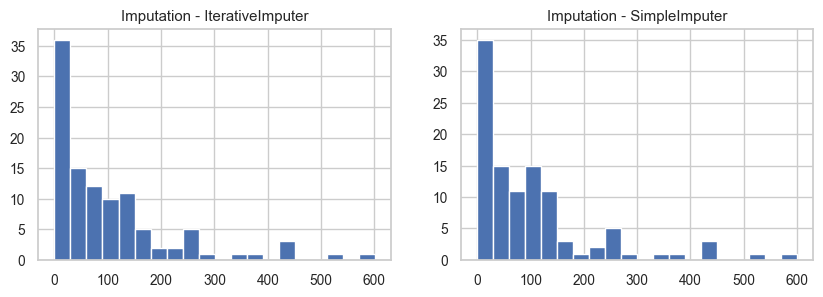

In [26]:
fig = plt.figure(figsize=(10,3))

plt.subplot(121)
X_test_it[var].hist(bins=20)
plt.title('Imputation - IterativeImputer')

plt.subplot(122)
X_test_mean[var].hist(bins=20)
plt.title('Imputation - SimpleImputer')
plt.show()

In [398]:
print("Voici les valeurs imputées dans l'ensemble de test avec la méthode itérative")
X_test_it.loc[X_test_it.index.isin(ix),:]

Voici les valeurs imputées dans l'ensemble de test avec la méthode itérative


DAYS_WITH_VALID_SUNSHINE  DAYS_WITH_VALID_PRECIP  MEAN_TEMPERATURE  \
307                       0.0                    88.0          6.657649   
172                       0.0                   119.0          6.807785   
77                        0.0                   365.0          7.338776   
478                       0.0                   366.0          7.009285   
131                       0.0                   179.5          6.967199   

     MIN_TEMPERATURE  DAYS_WITH_PRECIP_GE_1MM  TOTAL_SNOWFALL  \
307        -5.521808                     34.0           50.00   
172        -5.293181                     45.0           24.00   
77         -5.404177                    158.0          206.20   
478        -6.191796                    140.0          276.70   
131        -5.144148                     61.0           44.95   

     MAX_TEMPERATURE  TOTAL_PRECIPITATION   Annee  LATITUDE  
307        20.268005                215.3  2008.0    42.855  
172        20.186389                375.7  2012.0    42.855  
77         23.125456               1331.3  2013.0    43.002  
478        23.688535               1034.4  2016.0    43.863  
131        21.110851                509.1  2009.0    42.855

<Axes: >

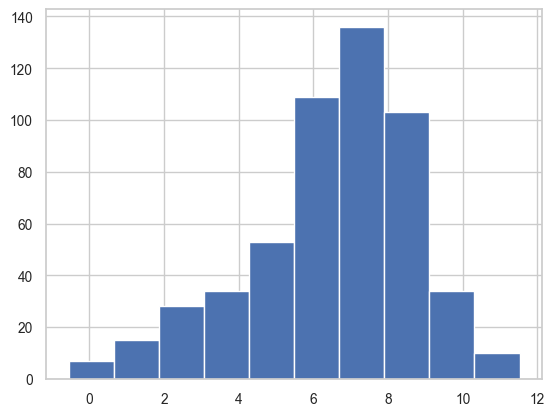

In [17]:
X.MEAN_TEMPERATURE.hist()

Quelle methode d'imputation choisir ?

La documentation de scikit learn est très complète.  Il existe d'autres méthodes qui peuvent être utilisées. 

https://scikit-learn.org/stable/modules/impute.html

Lorsque nous parlons de données manquantes, il faut faire attention pour ne pas introduire de biais. Les données peuvent être manquantes par hasard ou elles peuvent être manquantes pour des raisons bien particulières.

Il existe trois types de données manquantes : 

* données manquantes complètement au hasard (MCAR : missing completely at random)
* données manquantes au hasard (MAR : missing at random) 
* données manquantes non au hasard (MNAR : missing not at random) 

Le type de données manquantes et le choix de méthode peuvent avoir un impact sur la qualitdé des données.

Pour la suite, nous utiliserons les données imputées par la méthode itérative

In [28]:
X_train = X_train_it
X_test = X_test_it

### Corrélation entre les variables


Il est important d'évaluer la corrélation entre les variables.  Les algorithmes d'apprentissage ne se comportent pas tous de la même façon.  Certains performent mieux avec des données gaussiennes, d'autres sont très sensibles aux valeurs numériques et une transformation est nécessaire, d'autres sont sensibles aux variables corrélées entre elles.

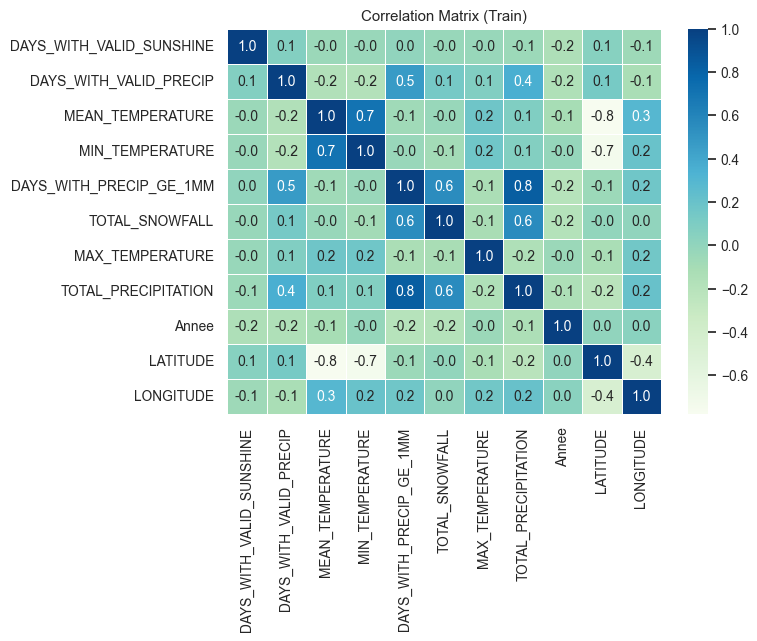

In [29]:
plt.figure(figsize=(7,5))
sns.heatmap(X_train.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Train)')
plt.show()

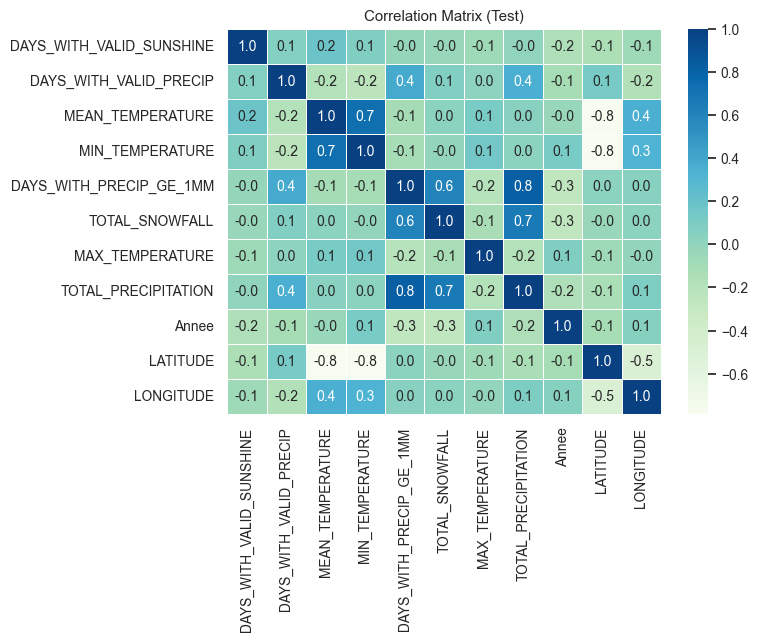

In [30]:
plt.figure(figsize=(7,5))
sns.heatmap(X_test.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Test)')
plt.show()

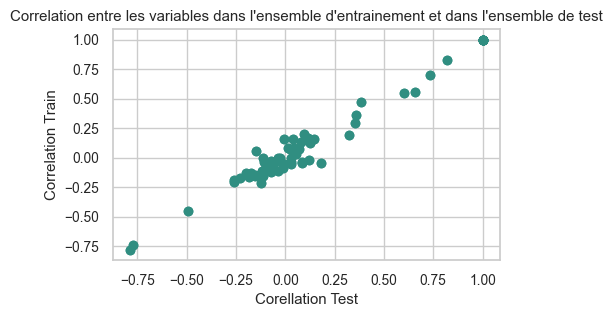

In [31]:
plt.figure(figsize=(5,3))
plt.scatter(X_test.corr(), X_train.corr(), color=colors[2])
plt.ylabel('Correlation Train')
plt.xlabel('Corellation Test')
plt.title ("Correlation entre les variables dans l'ensemble d'entrainement et dans l'ensemble de test")
plt.show()

## Transformation (normalisation, standardisation, encodage)

Des transformations sont parfois nécessaires tout dépendant des distributions des variables.  
Nous voudrons par exemple utiliser un encodage One-Hot pour les variables qualitatives (catégories) ou ramener les valeurs entre 0 et 1 pour les variables qui ne sont pas du même ordre de grandeur.

Ici, nous transformerons toutes les variables en z-score en utilisant la classe `StandardScaler`.

https://scikit-learn.org/stable/modules/preprocessing.html

In [33]:
scaler = StandardScaler().set_output(transform="pandas")
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Prédire le rendement d'avoine

La prédiction du rendement d'avoine est une tâche de régression.  Nous voulons prédire un nombre.

Nous pourrons évaluer la performance des modèles sur nos données regardant le coefficient de détermination ($R^2$) et la MSE (mean squared error).



Le `DummyRegressor` peut servir pour le prototypage de notre code.  Il utilise des règles très simples et expose les mêmes fonctions que les autres classes de `Regressor`.

In [34]:
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train_scaled, y_train)
y_pred = dummy_regressor.predict(X_test_scaled)
y_train_pred = dummy_regressor.predict(X_train_scaled)
score = dummy_regressor.score(X_test_scaled, y_test)

In [37]:
def plot_pred_vs_true(y_test, y_pred, score, model_name, y_train=None, y_train_pred=None):
    plt.figure(figsize=(4,3))
    if y_train is not None and y_train_pred is not None:
        plt.scatter(y_train, y_train_pred, label='Training data', color=colors[1])
        
    plt.scatter(y_test, y_pred, label='Test data', color=colors[0])
    plt.title('{} [test score={:.2f}]'.format(model_name, score))
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.legend()
    plt.ylim(y_test.min(), y_test.max())
    plt.show()

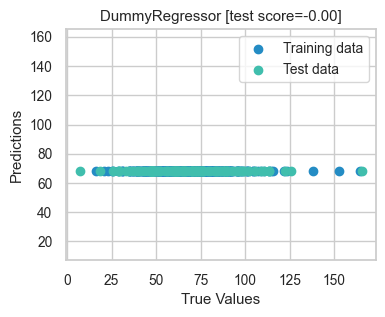

In [38]:
plot_pred_vs_true(y_test, y_pred, score, 'DummyRegressor', y_train=y_train, y_train_pred=y_train_pred)

### Forêt d'arbres aléatoire

Utilisons maintenant un `Regressor` plus pertinet, soit une forêt alétaoire (*random forest*) 

La forêt de décitsion aléatoire est une méthode d'ensemble qui peut être utilisée pour les problèmes de régression et de classification  Cet algorithme non linéaire combine les prédictions de plusieurs arbres de décision.  Chaque arbre de décision de la forêt est entrainé en utilisant des caractéristiques et des exemples choisis au hasard. 

<img src='https://www.tibco.com/sites/tibco/files/media_entity/2021-05/random-forest-diagram.svg' width='450px'>

<a style='font-size:10px;' href='https://www.tibco.com/fr/reference-center/what-is-a-random-forest'>https://www.tibco.com/fr/reference-center/what-is-a-random-forest</a>

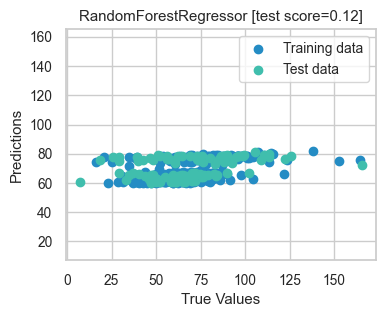

In [82]:
forest_regressor = RandomForestRegressor(max_depth=2, random_state=0)
forest_regressor.fit(X_train_scaled, y_train)
y_pred = forest_regressor.predict(X_test_scaled)
y_train_pred = forest_regressor.predict(X_train_scaled)
score = forest_regressor.score(X_test_scaled, y_test)
plot_pred_vs_true(y_test, y_pred, score, 'RandomForestRegressor', y_train=y_train, y_train_pred=y_train_pred)


In [93]:

mse = np.sqrt(mean_squared_error(y_test,y_pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(y_pred)*100:3.3}%)')

score = forest_regressor.score(X_test_scaled, y_test)
print(f'Model determination: {score:3.3}')

Mean error: 23.0 (32.8%)
Model determination: 0.12


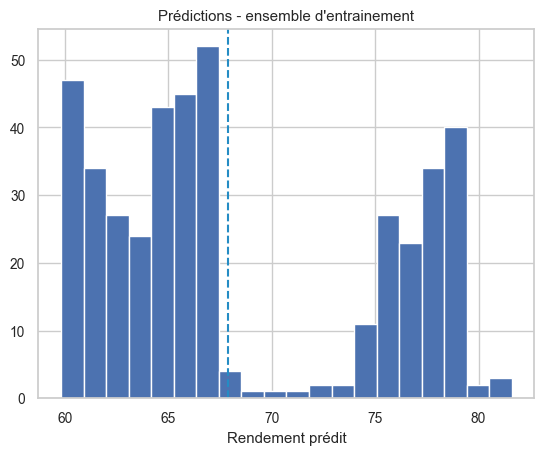

In [52]:
plt.hist(y_train_pred, bins=20)
plt.title("Prédictions - ensemble d'entrainement")
plt.axvline(x=y_test.mean(), color=colors[1], linestyle='--')
plt.xlabel('Rendement prédit')
plt.show()

Pourquoi une distribution bi-modale et des prédictions qui se situent entre 60 et 85 seulement ?
On ne s'éloigne pas beaucoup de la moyenne.

In [63]:
X_train.loc[y_train_pred < 70,:].describe().T

count         mean         std          min  \
DAYS_WITH_VALID_SUNSHINE  278.0     1.053062    7.194491     0.000000   
DAYS_WITH_VALID_PRECIP    278.0   346.601493   26.169404   202.000000   
MEAN_TEMPERATURE          278.0     7.287149    1.811626     1.259211   
MIN_TEMPERATURE           278.0   -28.611129    5.911111   -42.766667   
DAYS_WITH_PRECIP_GE_1MM   278.0   119.541160   21.302872    62.500000   
TOTAL_SNOWFALL            278.0   116.106276   93.344802     0.000000   
MAX_TEMPERATURE           278.0    32.920031    2.011602    26.000000   
TOTAL_PRECIPITATION       278.0   887.025922  167.157132   419.900000   
Annee                     278.0  2009.989209    4.840774  2004.000000   
LATITUDE                  278.0    45.003585    1.719003    42.059667   
LONGITUDE                 278.0   -79.595983    3.514723   -93.031000   

                                  25%          50%          75%          max  
DAYS_WITH_VALID_SUNSHINE     0.000000     0.000000     0.000000    60.645833  
DAYS_WITH_VALID_PRECIP     340.125000   357.666667   363.500000   366.000000  
MEAN_TEMPERATURE             6.363549     7.551926     8.363683    11.968148  
MIN_TEMPERATURE            -33.156250   -28.716667   -24.500000   -13.833333  
DAYS_WITH_PRECIP_GE_1MM    105.450000   118.500000   134.000000   201.000000  
TOTAL_SNOWFALL              47.016667    98.050000   172.875000   458.150000  
MAX_TEMPERATURE             31.500000    33.083333    34.325000    37.500000  
TOTAL_PRECIPITATION        769.854167   900.133333   998.587500  1316.200000  
Annee                     2006.000000  2009.000000  2012.000000  2022.000000  
LATITUDE                    43.958500    44.717333    45.339500    51.026250  
LONGITUDE                  -81.506667   -79.283333   -77.262687   -74.963000

In [64]:
X_train.loc[y_train_pred > 70,:].describe().T

count         mean         std          min  \
DAYS_WITH_VALID_SUNSHINE  145.0     0.000000    0.000000     0.000000   
DAYS_WITH_VALID_PRECIP    145.0   342.678870   26.792210   220.000000   
MEAN_TEMPERATURE          145.0     6.739667    2.618585    -0.479620   
MIN_TEMPERATURE           145.0   -27.924499    7.001313   -42.833333   
DAYS_WITH_PRECIP_GE_1MM   145.0   113.518774   22.235854    33.500000   
TOTAL_SNOWFALL            145.0    98.772823  108.316896     0.000000   
MAX_TEMPERATURE           145.0    32.413416    1.705386    27.400000   
TOTAL_PRECIPITATION       145.0   838.582582  187.436568   225.600000   
Annee                     145.0  2016.834483    3.308268  2012.000000   
LATITUDE                  145.0    45.006118    2.124305    42.032000   
LONGITUDE                 145.0   -81.766355    3.016483   -92.563333   

                                  25%          50%          75%          max  
DAYS_WITH_VALID_SUNSHINE     0.000000     0.000000     0.000000     0.000000  
DAYS_WITH_VALID_PRECIP     337.500000   350.500000   359.000000   366.000000  
MEAN_TEMPERATURE             5.372143     6.996544     8.702634    11.645574  
MIN_TEMPERATURE            -33.785714   -27.000000   -22.750000   -15.300000  
DAYS_WITH_PRECIP_GE_1MM     99.500000   111.250000   128.500000   180.000000  
TOTAL_SNOWFALL              35.725000    74.942857   125.000000   623.600000  
MAX_TEMPERATURE             31.366667    32.466667    33.533333    36.775000  
TOTAL_PRECIPITATION        703.000000   829.500000   951.200000  1551.400000  
Annee                     2014.000000  2016.000000  2020.000000  2022.000000  
LATITUDE                    43.576500    44.259500    46.121750    51.129556  
LONGITUDE                  -81.982000   -80.910500   -79.899333   -78.960000

Le résultat du modèle n'est pas très bon. Nous pouvons tout de même 
regarder quelles variables ont contribué le plus à la prédiction du rendement en récupérant l'`importance` (contribution au modèle) de chacune des caractéristiques.

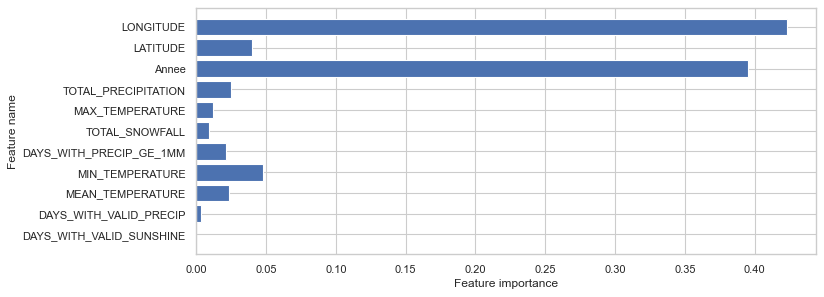

In [58]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train_scaled.columns)
plt.barh(range(c_features), forest_regressor.feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train_scaled.columns)
plt.show()


Nous pouvons voir que l'année et la longitude sont les deux variables qui ont le plus contribué.

### Régression linéaire

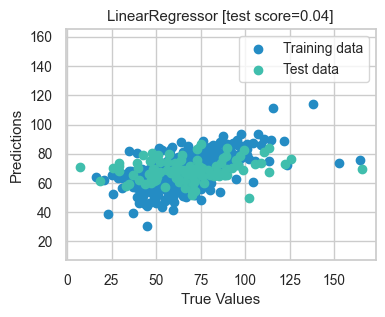

In [103]:

linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, y_train)
test_score = linear_regressor.score(X_test_scaled, y_test)
train_score = linear_regressor.score(X_train_scaled, y_train)
y_pred = linear_regressor.predict(X_test_scaled)
plot_pred_vs_true(y_test, y_pred, test_score, 'LinearRegressor', y_train=y_train, y_train_pred=y_train_pred)

intercept: 68.31915116691103
coef: [('DAYS_WITH_VALID_SUNSHINE', -0.11495347711936335), ('DAYS_WITH_VALID_PRECIP', 0.38441013593718465), ('MEAN_TEMPERATURE', -0.5919853967351498), ('MIN_TEMPERATURE', 1.741508297967096), ('DAYS_WITH_PRECIP_GE_1MM', 6.763906929746638), ('TOTAL_SNOWFALL', -0.7839904559826778), ('MAX_TEMPERATURE', -2.1982176968619522), ('TOTAL_PRECIPITATION', -6.74079228002595), ('Annee', 4.537481766648213), ('LATITUDE', -2.451112960069946), ('LONGITUDE', -1.8918107533910793)]


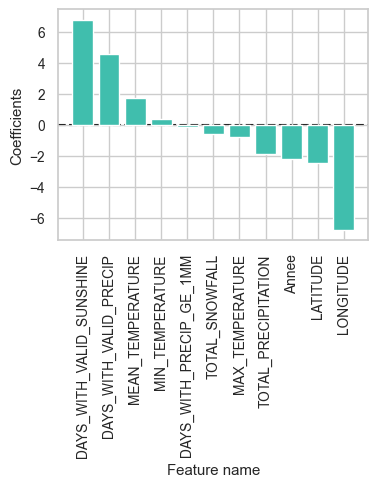

In [109]:
print('intercept:', linear_regressor.intercept_)
print('coef:', list(zip(X_train.columns, linear_regressor.coef_) ))

coefficients = pd.DataFrame(list(zip(X_train.columns, linear_regressor.coef_)), 
                            columns=['features', 'coefficients'])
coefficients.sort_values(by='coefficients', ascending=False, inplace=True)
plt.figure(figsize=(4,3))
#plt.barh(range(len(coefficients)), coefficients.coefficients)
plt.bar(range(len(coefficients)), coefficients.coefficients, color=colors[0])
plt.ylabel("Coefficients")
plt.xlabel("Feature name")
plt.xticks(np.arange(len(coefficients)), X_train_scaled.columns, rotation=90)
plt.axhline(y=0, color='black', linestyle='--', zorder=-1000)
plt.show()



### À votre tour 

<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Que peut-on observer ici ?

Encore une fois les résultats ne sont pas très bons.  Regardons la différence entre la valeur prédite et la vraie valeur

In [43]:
res = pd.DataFrame(list(zip(y_pred, y_test)), columns=['pred', 'test'], index=y_test.index)
res['Annee'] = df.loc[y_test.index, 'Annee'].astype(int)
res['Region'] = df.loc[y_test.index, 'Region']
res['Ensemencee'] = df.loc[y_test.index, 'Ensemencee']
res['Recoltee'] = df.loc[y_test.index, 'Recoltee']
res['Rendement'] = df.loc[y_test.index, 'Rendement']
res['diff'] = res.pred - res.test
res.sort_values('diff', inplace=True)
res.head()

<Axes: >

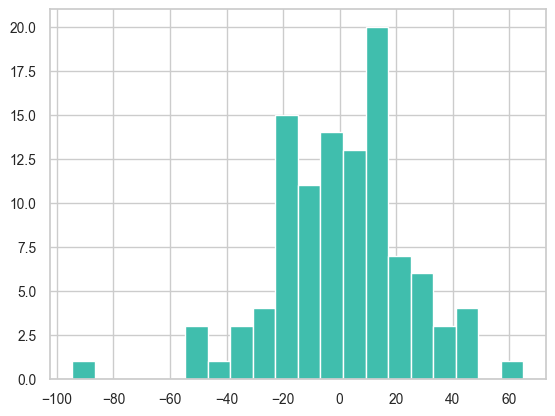

In [44]:
res['diff'].hist(bins=20, color=colors[0])

### Régression linéaire avec la librairie statsmodels

In [110]:
# Autre package pour effectuer des regressions rapidement.  Nous allons l'utiliser pour calculer les p-values
X_sm = X_train_scaled.copy()
X_sm = sm.add_constant(X_sm)
model = sm.OLS(y_train, X_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Rendement   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     5.317
Date:                Fri, 14 Jul 2023   Prob (F-statistic):           6.90e-08
Time:                        16:19:08   Log-Likelihood:                -1810.8
No. Observations:                 423   AIC:                             3646.
Df Residuals:                     411   BIC:                             3694.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

### Quels sont les autres modèles que nous pourrions essayer ?

Nous nous rendons compte que nous devons bien nous organiser pour tester différents pré-traitements, modèles et hyperparamètres. 
Ceci doit être fait en utilisant une stratégie de validation croisée pour s'assurer que le modèle final puisse généraliser à des données jamais vues.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html
    
<img src="https://scikit-learn.org/stable/_static/ml_map.png"/>

## Pipelines de Scikit Learn 

Il y a plusieurs combinaisons possibles à tester.  Nous nous retrouvons rapidement avec plusieurs expériences à organiser.  

Aussi, si on obtient un résultat intéressant, on veut savoir exactement les paramètres que nous avons utilisés.  

Les pipelines de scikit-learn nous aide à nous organiser et font sauver du temps et des lignes de code.  Nous pourrions aussi utiliser des logiciels comme kedro ou Knime.   L'auto ML est aussi de plus en plus populaire.

Un pipeline applique séquentiellement différentes opérations.

Dans les pipelines de scikit-learn, nous retrouvons 2 concepts importants:

* les transformateurs (transformer) qui offrent les fonctions <span style='font-family:monospace'>fit</span> et <span style='font-family:monospace'>transform</span>
* les estimateurs (estimators) qui offrent les fonctions <span style='font-family:monospace'>fit</span> et <span style='font-family:monospace'>predict</span>

La fonction `make_pipeline` gère l'enchainement des différentes étapes de pré-traitement et d'entrainement.

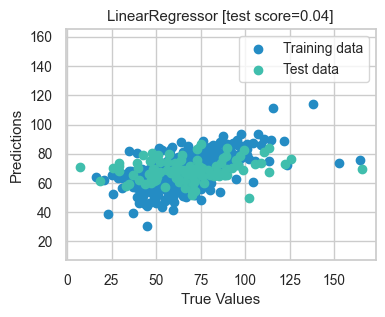

In [113]:
pipeline = make_pipeline(SimpleImputer(), StandardScaler(), LinearRegression(fit_intercept=True))
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
test_score = pipeline.score(X_test, y_test)
plot_pred_vs_true(y_test, y_pred, test_score, 'LinearRegressor', y_train=y_train, y_train_pred=y_train_pred)

La classe `Pipeline` gère aussi l'enchainement séquentiel des différentes étapes.  Ici, nous avons besoin de nommer les étapes.  Avec `make_pipeline`, les noms sont créés automatiquement.

Nous pouvons passer l'objet `pipeline` à la méthode `cross_val_score` pour effectuer la validation croisée. 

In [121]:
results = []
estimator_names = ['LinearRegression', 'RandomForestRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor',
                   'GradientBoostingRegressor', 'SVR']
for estimator in estimator_names:
    pipeline = Pipeline([ ('imputer', IterativeImputer(max_iter=10, random_state=0)),
                          ('scaler', StandardScaler()),
                          ('estimator', eval(estimator)()) 
                            ])
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, n_jobs=-1)
    results.append([estimator, np.mean(scores), np.std(scores), 'Rendement'])
    
results = pd.DataFrame(results, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results

Model  Mean Score  Std Score    Dataset
0           LinearRegression   -0.024327   0.254808  Rendement
1      RandomForestRegressor    0.087724   0.263155  Rendement
2      DecisionTreeRegressor   -0.688431   0.577879  Rendement
3        KNeighborsRegressor    0.075317   0.215065  Rendement
4  GradientBoostingRegressor   -0.025392   0.306395  Rendement
5                        SVR    0.029285   0.127069  Rendement

Un coefficient de détermination négatif indique que quelque chose ne fonctionne pas.  Cela indique que le modèle de régression n'est pas capable de capturer la variation des données et qu'il effectue des prédictions moins précices qu'en utilisant simplement la moyenne.  

Quoi faire ?

* S'assurer que le code est correct 
* Vérifier les données tant les variables prédictives que la variable à prédire
* Retourner aux données pour comprendre le problème

Comme nous n'obtenons pas de très bons résultats, nous pouvons tester notre code avec des données sythétiques en utilisant la fonction `make_regression`.

In [124]:
X_tmp, y_tmp = make_regression(n_samples=X.shape[0], n_features=X.shape[1])

results_tmp = []
for estimator in estimator_names:
    pipeline = make_pipeline(IterativeImputer(), StandardScaler(), eval(estimator)())
    cv = KFold(n_splits=10)
    scores = cross_val_score(pipeline, X_tmp, y_tmp, cv=cv, n_jobs=-1)
    results_tmp.append([estimator, np.mean(scores), np.std(scores), 'scikit-learn'])

results_tmp = pd.DataFrame(results_tmp, columns=['Model', 'Mean Score', 'Std Score', 'Dataset'])
results_tmp

Model  Mean Score  Std Score       Dataset
0           LinearRegression    1.000000   0.000000  scikit-learn
1      RandomForestRegressor    0.783506   0.017866  scikit-learn
2      DecisionTreeRegressor    0.365403   0.092122  scikit-learn
3        KNeighborsRegressor    0.708482   0.046024  scikit-learn
4  GradientBoostingRegressor    0.887643   0.015055  scikit-learn
5                        SVR    0.099435   0.038492  scikit-learn

### À votre tour 

<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Que concluez-vous de ces résultats ?

## Trouver les bons paramètres et le bon modèle

Chaque algorithme d'apprentissage a ses particularités et certains modèles sont plus appropriés pour certains types de données et problèmes.  

En tenant compte de nos contraintes pratiques, nous voulons tester différents algorithmes sur les données traitées de différentes façons.  Nous voulons aussi optimiser les hyperparamètres des algorithmes testés.  

Cela fait beaucoup de combinaisons possibles.  Les `pipeline`de `scikit-learn` favorisent la traçabilité, la reproductibilité et l'automatisation.


In [198]:
estimator_names = ['LinearRegression', 'RandomForestRegressor',  'KNeighborsRegressor',
                   'GradientBoostingRegressor', 'SVR', 'DummyRegressor']

estimator_params = {
    'RandomForestRegressor': {'estimator__max_depth': [4, 6, 8, 10, 12]},
}

res = []

for estimator in estimator_names:
    
    pipeline = Pipeline([
        ('imputer', None),
        ('scaler', None),  #
        ('estimator', eval(estimator)()) 
    ])
    parameters = {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'imputer': [SimpleImputer(), IterativeImputer()],
    }
   
    parameters.update(estimator_params.get(estimator, {}))
    
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring="r2")  
    grid_search.fit(X_train, y_train) 
    cv_results = grid_search.cv_results_
    best_estimator = grid_search.best_estimator_     
    res.append([estimator, grid_search.best_score_, grid_search.best_params_, cv_results, best_estimator]) 
res = pd.DataFrame(res, columns=['Model', 'Best_Score', 'Best_parameters', 'CV_Results', 'Best_estimator'])
#res.to_csv('prediction_rendement_20230707.csv')

Model  Best_Score  \
0           LinearRegression    0.046245   
1      RandomForestRegressor    0.179519   
2        KNeighborsRegressor    0.168386   
3  GradientBoostingRegressor    0.055765   
4                        SVR    0.075216   
5             DummyRegressor   -0.005849   

                                     Best_parameters  \
0  {'imputer': SimpleImputer(), 'scaler': MinMaxS...   
1  {'estimator__max_depth': 10, 'imputer': Iterat...   
2  {'imputer': SimpleImputer(), 'scaler': Standar...   
3  {'imputer': SimpleImputer(), 'scaler': MinMaxS...   
4  {'imputer': SimpleImputer(), 'scaler': Standar...   
5  {'imputer': SimpleImputer(), 'scaler': Standar...   

                                          CV_Results  \
0  {'mean_fit_time': [0.005431413650512695, 0.005...   
1  {'mean_fit_time': [0.23702425956726075, 0.2283...   
2  {'mean_fit_time': [0.003614664077758789, 0.004...   
3  {'mean_fit_time': [0.10385942459106445, 0.1060...   
4  {'mean_fit_time': [0.012691926956176759, 0.009...   
5  {'mean_fit_time': [0.0033878803253173826, 0.00...   

                                      Best_estimator  
0  (SimpleImputer(), MinMaxScaler(), LinearRegres...  
1  (IterativeImputer(), MinMaxScaler(), (Decision...  
2  (SimpleImputer(), StandardScaler(), KNeighbors...  
3  (SimpleImputer(), MinMaxScaler(), ([DecisionTr...  
4         (SimpleImputer(), StandardScaler(), SVR())  
5  (SimpleImputer(), StandardScaler(), DummyRegre...

Regardons les résultats obtenus

In [199]:
res

Model  Best_Score  \
0           LinearRegression    0.046245   
1      RandomForestRegressor    0.179519   
2        KNeighborsRegressor    0.168386   
3  GradientBoostingRegressor    0.055765   
4                        SVR    0.075216   
5             DummyRegressor   -0.005849   

                                     Best_parameters  \
0  {'imputer': SimpleImputer(), 'scaler': MinMaxS...   
1  {'estimator__max_depth': 10, 'imputer': Iterat...   
2  {'imputer': SimpleImputer(), 'scaler': Standar...   
3  {'imputer': SimpleImputer(), 'scaler': MinMaxS...   
4  {'imputer': SimpleImputer(), 'scaler': Standar...   
5  {'imputer': SimpleImputer(), 'scaler': Standar...   

                                          CV_Results  \
0  {'mean_fit_time': [0.005431413650512695, 0.005...   
1  {'mean_fit_time': [0.23702425956726075, 0.2283...   
2  {'mean_fit_time': [0.003614664077758789, 0.004...   
3  {'mean_fit_time': [0.10385942459106445, 0.1060...   
4  {'mean_fit_time': [0.012691926956176759, 0.009...   
5  {'mean_fit_time': [0.0033878803253173826, 0.00...   

                                      Best_estimator  
0  (SimpleImputer(), MinMaxScaler(), LinearRegres...  
1  (IterativeImputer(), MinMaxScaler(), (Decision...  
2  (SimpleImputer(), StandardScaler(), KNeighbors...  
3  (SimpleImputer(), MinMaxScaler(), ([DecisionTr...  
4         (SimpleImputer(), StandardScaler(), SVR())  
5  (SimpleImputer(), StandardScaler(), DummyRegre...

À quoi ressemblent les résultats de validation croisée ? 

In [200]:
res['CV_Results'][0]

{'mean_fit_time': array([0.00543141, 0.00534949, 0.00631399, 0.02534533, 0.04110661,
        0.03291535]),
 'std_fit_time': array([0.00192429, 0.00102539, 0.00036821, 0.00640875, 0.01607069,
        0.00605998]),
 'mean_score_time': array([0.00160942, 0.00216718, 0.00165544, 0.0018734 , 0.0030067 ,
        0.00236001]),
 'std_score_time': array([1.01608236e-04, 6.31490382e-04, 1.56801329e-04, 7.62517037e-05,
        1.14187208e-03, 7.99206028e-04]),
 'param_imputer': masked_array(data=[SimpleImputer(), SimpleImputer(), SimpleImputer(),
                    IterativeImputer(), IterativeImputer(),
                    IterativeImputer()],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_scaler': masked_array(data=[StandardScaler(), MinMaxScaler(), RobustScaler(),
                    StandardScaler(), MinMaxScaler(), RobustScaler()],
              mask=[False, False, False, False, False, False],
        fill_value='?'

### Calcul de différentes métriques pour les meilleurs modèles choisis.

In [201]:
metric_names = [ "mean_absolute_error", 'mean_squared_error', "r2_score"] # même nom que dans la librairie

metrics = []
for row in res.to_dict('records'):
    model = row['Model']
    estimator = row['Best_estimator']
    pred_test = estimator.fit(X_train, y_train).predict(X_test)
    m = []
    for metric_name in metric_names:
        m.append(eval(f'{metric_name}(y_test, pred_test)'))
    metrics.append([model] + m)
metrics =  pd.DataFrame(metrics, columns=['Model']+metric_names)

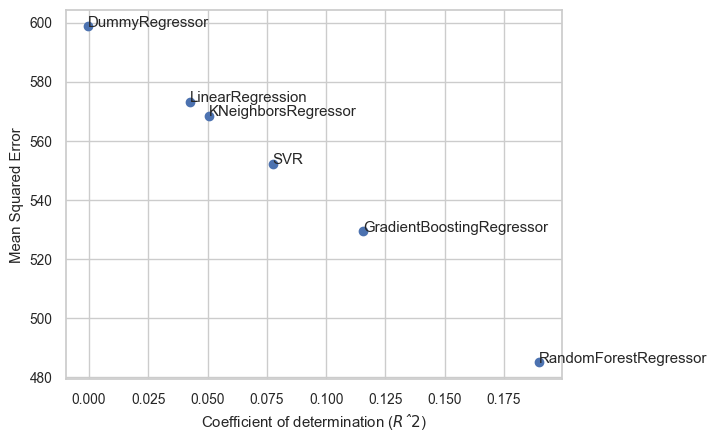

In [203]:
plt.scatter(metrics.r2_score, metrics.mean_squared_error)
for i in range(metrics.shape[0]):
    plt.text(metrics.r2_score[i], metrics.mean_squared_error[i], s=metrics.Model[i])
plt.ylabel('Mean Squared Error')
plt.xlabel('Coefficient of determination ($Rˆ2$)')
plt.show()

Voici un article s'intéressant à la prédiction du rendement: <br>
    https://www.frontiersin.org/articles/10.3389/fpls.2019.00621/full

Et un rapport produit dans le cadre d'une compétition:<br>
https://github.com/WizzX7/Morgan-Stanley-Quant-Challange/blob/main/quant_documentation.pdf


# Prédiction du type de culture en fonction du sol et de la météo



"Precision agriculture is in trend nowadays. It helps the farmers to get informed decision about the farming strategy. Here, I present you a dataset which would allow the users to build a predictive model to recommend the most suitable crops to grow in a particular farm based on various parameters.  This dataset was build by augmenting datasets of rainfall, climate and fertilizer data available for India."

<a href='https://www.kaggle.com/code/theeyeschico/crop-analysis-and-prediction/input'> https://www.kaggle.com/code/theeyeschico/crop-analysis-and-prediction/input </a>


Le but est de prédire (recommender) un type de culture en utilisant les données météo et de composition du sol. 

La tâche est une tâche de classification, le type de culture est l'étiquette.  Nous nous déplaçons dans une autre partie du monde, en Inde.




Le jeu de données contient les caractéristiques suivantes: 
    
* N - ratio of Nitrogen content in soil
* P - ratio of Phosphorous content in soil
* K - ratio of Potassium content in soil
* temperature - temperature in degree Celsius
* humidity - relative humidity in %
* ph - ph value of the soil
* rainfall - rainfall in mm

## Chargement du jeu de données

In [208]:
file_id = '1MaQiHpeeggzS2-7dedjU-jwgNv5CDPsE'
google_url_format = "https://drive.google.com/uc?export=view&id=%s"
myfile = google_url_format % file_id 
mf = pd.read_csv(myfile)
mf['label'] = mf.label.astype('category')

Regardons les données

In [209]:
mf.head()

N   P   K  temperature   humidity        ph    rainfall label
0  90  42  43    20.879744  82.002744  6.502985  202.935536  rice
1  85  58  41    21.770462  80.319644  7.038096  226.655537  rice
2  60  55  44    23.004459  82.320763  7.840207  263.964248  rice
3  74  35  40    26.491096  80.158363  6.980401  242.864034  rice
4  78  42  42    20.130175  81.604873  7.628473  262.717340  rice

## À votre tour  - Break room - équipe de 3


<img style='float:right;'  src='https://drive.google.com/uc?export=view&id=1HMGzZe3dGBk9Zgpk0tKtbQarFu3WMrBK' width='100px'>  </a>

Explorer les données à l'aide de graphiques et de tableaux (1-2 graphique(s))

Suggestions : 
* Pairplot de seaborn
* Graphique de distribution
* Nombre de valeurs manquantes 


Qu'avez-vous observé ?

<h3> Nombre de valeurs manquantes </h3>

Cela nous indique si nous devons ajouter une étape d'imputation des valeurs manquantes.

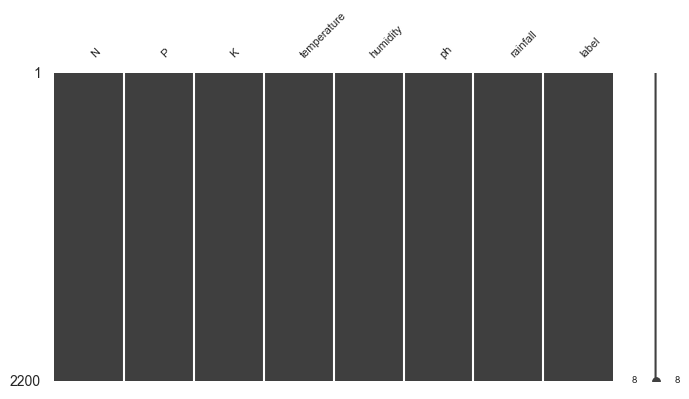

In [210]:
missingno.matrix(mf, figsize=(8,4), fontsize=8)
plt.show()

<h3> Nombre d'exemples par classe </h3>

Cela nous indique si les classes sont bien balancées. Lorsque les classes sont débalancées, nous devons nous assurer d'ajuster notre *baseline* et notre définition de succès.  Nous devons aussi prendre des précautions au niveau de la validation croisée.

<img src='https://user.oc-static.com/upload/2017/02/27/14881893858847_P2C2-3.png' width='300px'/>


<a href='https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308241-mettez-en-place-un-cadre-de-validation-croisee'>https://openclassrooms.com/fr/courses/4297211-evaluez-les-performances-dun-modele-de-machine-learning/4308241-mettez-en-place-un-cadre-de-validation-croisee</a>


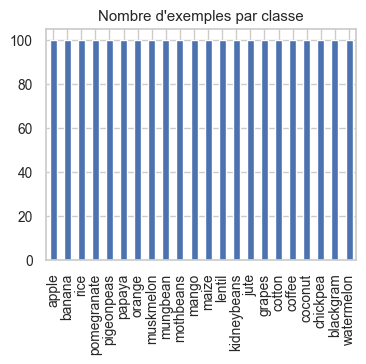

In [211]:
plt.figure(figsize=(4,3))
mf.label.value_counts().plot(kind='bar', title="Nombre d'exemples par classe")
plt.show()

<h3> Valeur moyenne de chaque caractéristique par classe </h3>

Cela nous donne une idée de la variabilité pour chacune des classes.  Par exemple, nous pouvons tout de suite présumer que le ph sera peu informatif et peu utile pour discriminer les différentes sortes de cultures.

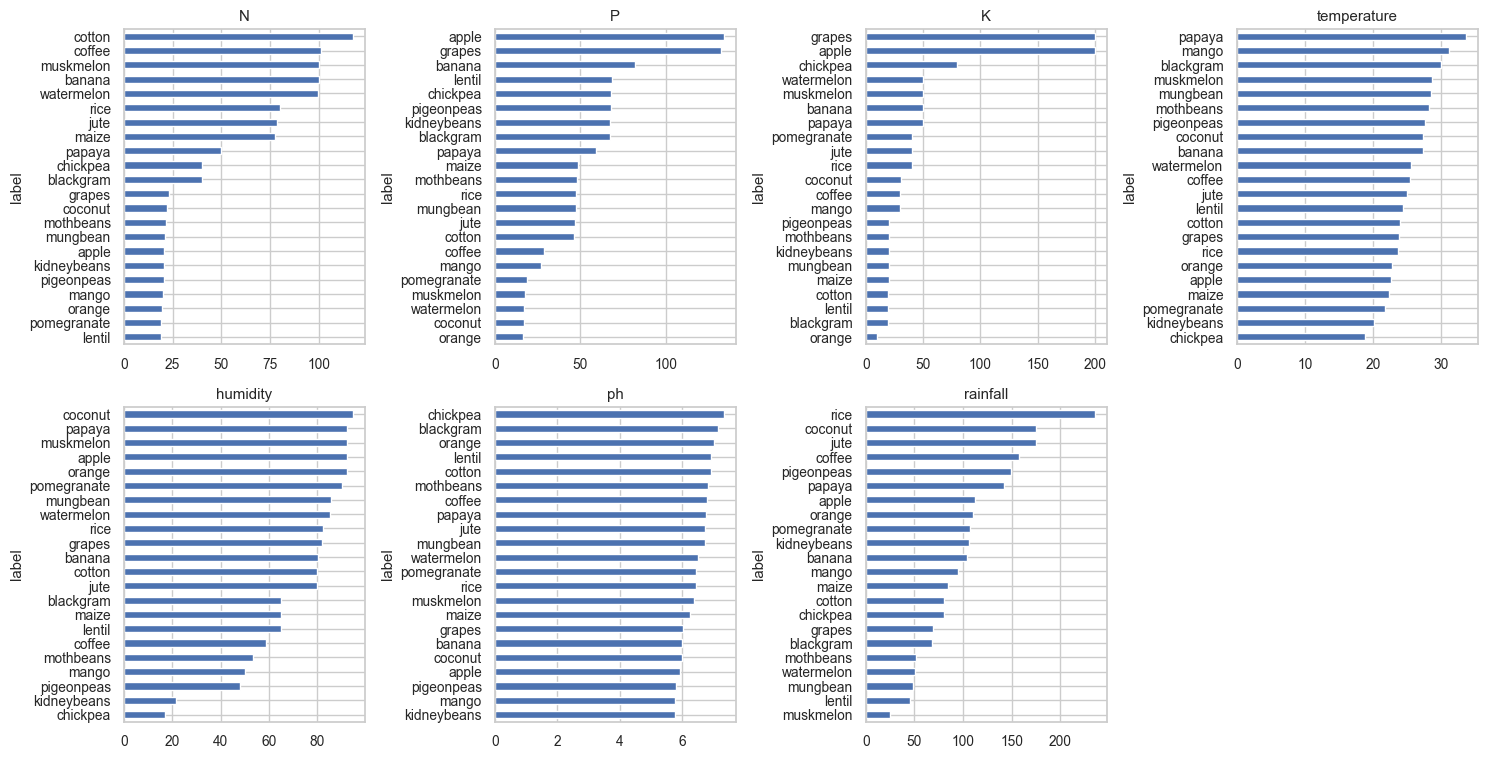

In [215]:

nc = 4
nr = math.ceil((len(cols)/nc)+1)
i = 1
g = mf.groupby('label')
fig = plt.figure(figsize=(15,15))
for col in mf.columns: 
    if col=='label':
        continue
    plt.subplot(nr,nc,i)
    g.mean()[col].sort_values().plot(kind='barh', title=col)
    i += 1
plt.tight_layout()
plt.show()

### Visualisation par radar plot

Nous permet de comparer directement plusieurs classes en regardant des caractérisitques choisies.  Cette visualisation s'avère utile pour les petits jeux de données.

In [218]:
#https://www.pythoncharts.com/matplotlib/radar-charts/

def radarplot(crop, color='doderblue', ax=None):
    g = mf.groupby('label').mean()
    features = g.columns
    # Normalisation
    g = (g - g.min(0)) / (g.max(0) - g.min(0))
    values = g.loc[crop, :].values
    num_features = len(features)
    angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
    if ax is None:
        _, ax = plt.subplots(figsize=(3, 3), subplot_kw=dict(polar=True))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), features)

    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
   
    ax.set_ylim(0, 1)
    ax.set_rlabel_position(180 / num_features)
    ax.tick_params(colors='#222222')
    ax.tick_params(axis='y', labelsize=8)
    ax.grid(color='#AAAAAA')
    ax.spines['polar'].set_color('#222222')
    ax.set_facecolor('#FAFAFA')
    ax.plot(angles, values, color=color, linewidth=1, label=crop)
    ax.fill(angles, values, color=color, alpha=0.25)
    ax.set_title(F"Caractéristiques", y=1.18)
    return ax

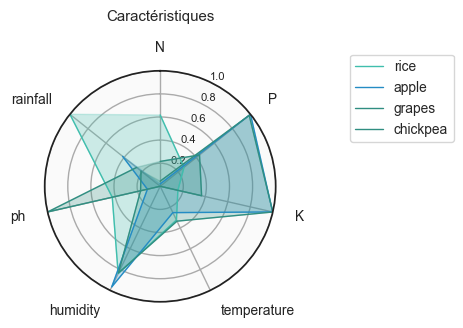

In [219]:
ax = radarplot('rice', color=colors[0])
ax = radarplot('apple', color=colors[1], ax=ax)
ax = radarplot('grapes', color=colors[2], ax=ax)
ax = radarplot('chickpea', color=colors[2], ax=ax)
plt.legend(bbox_to_anchor=(1.8, 1.1))
plt.show()

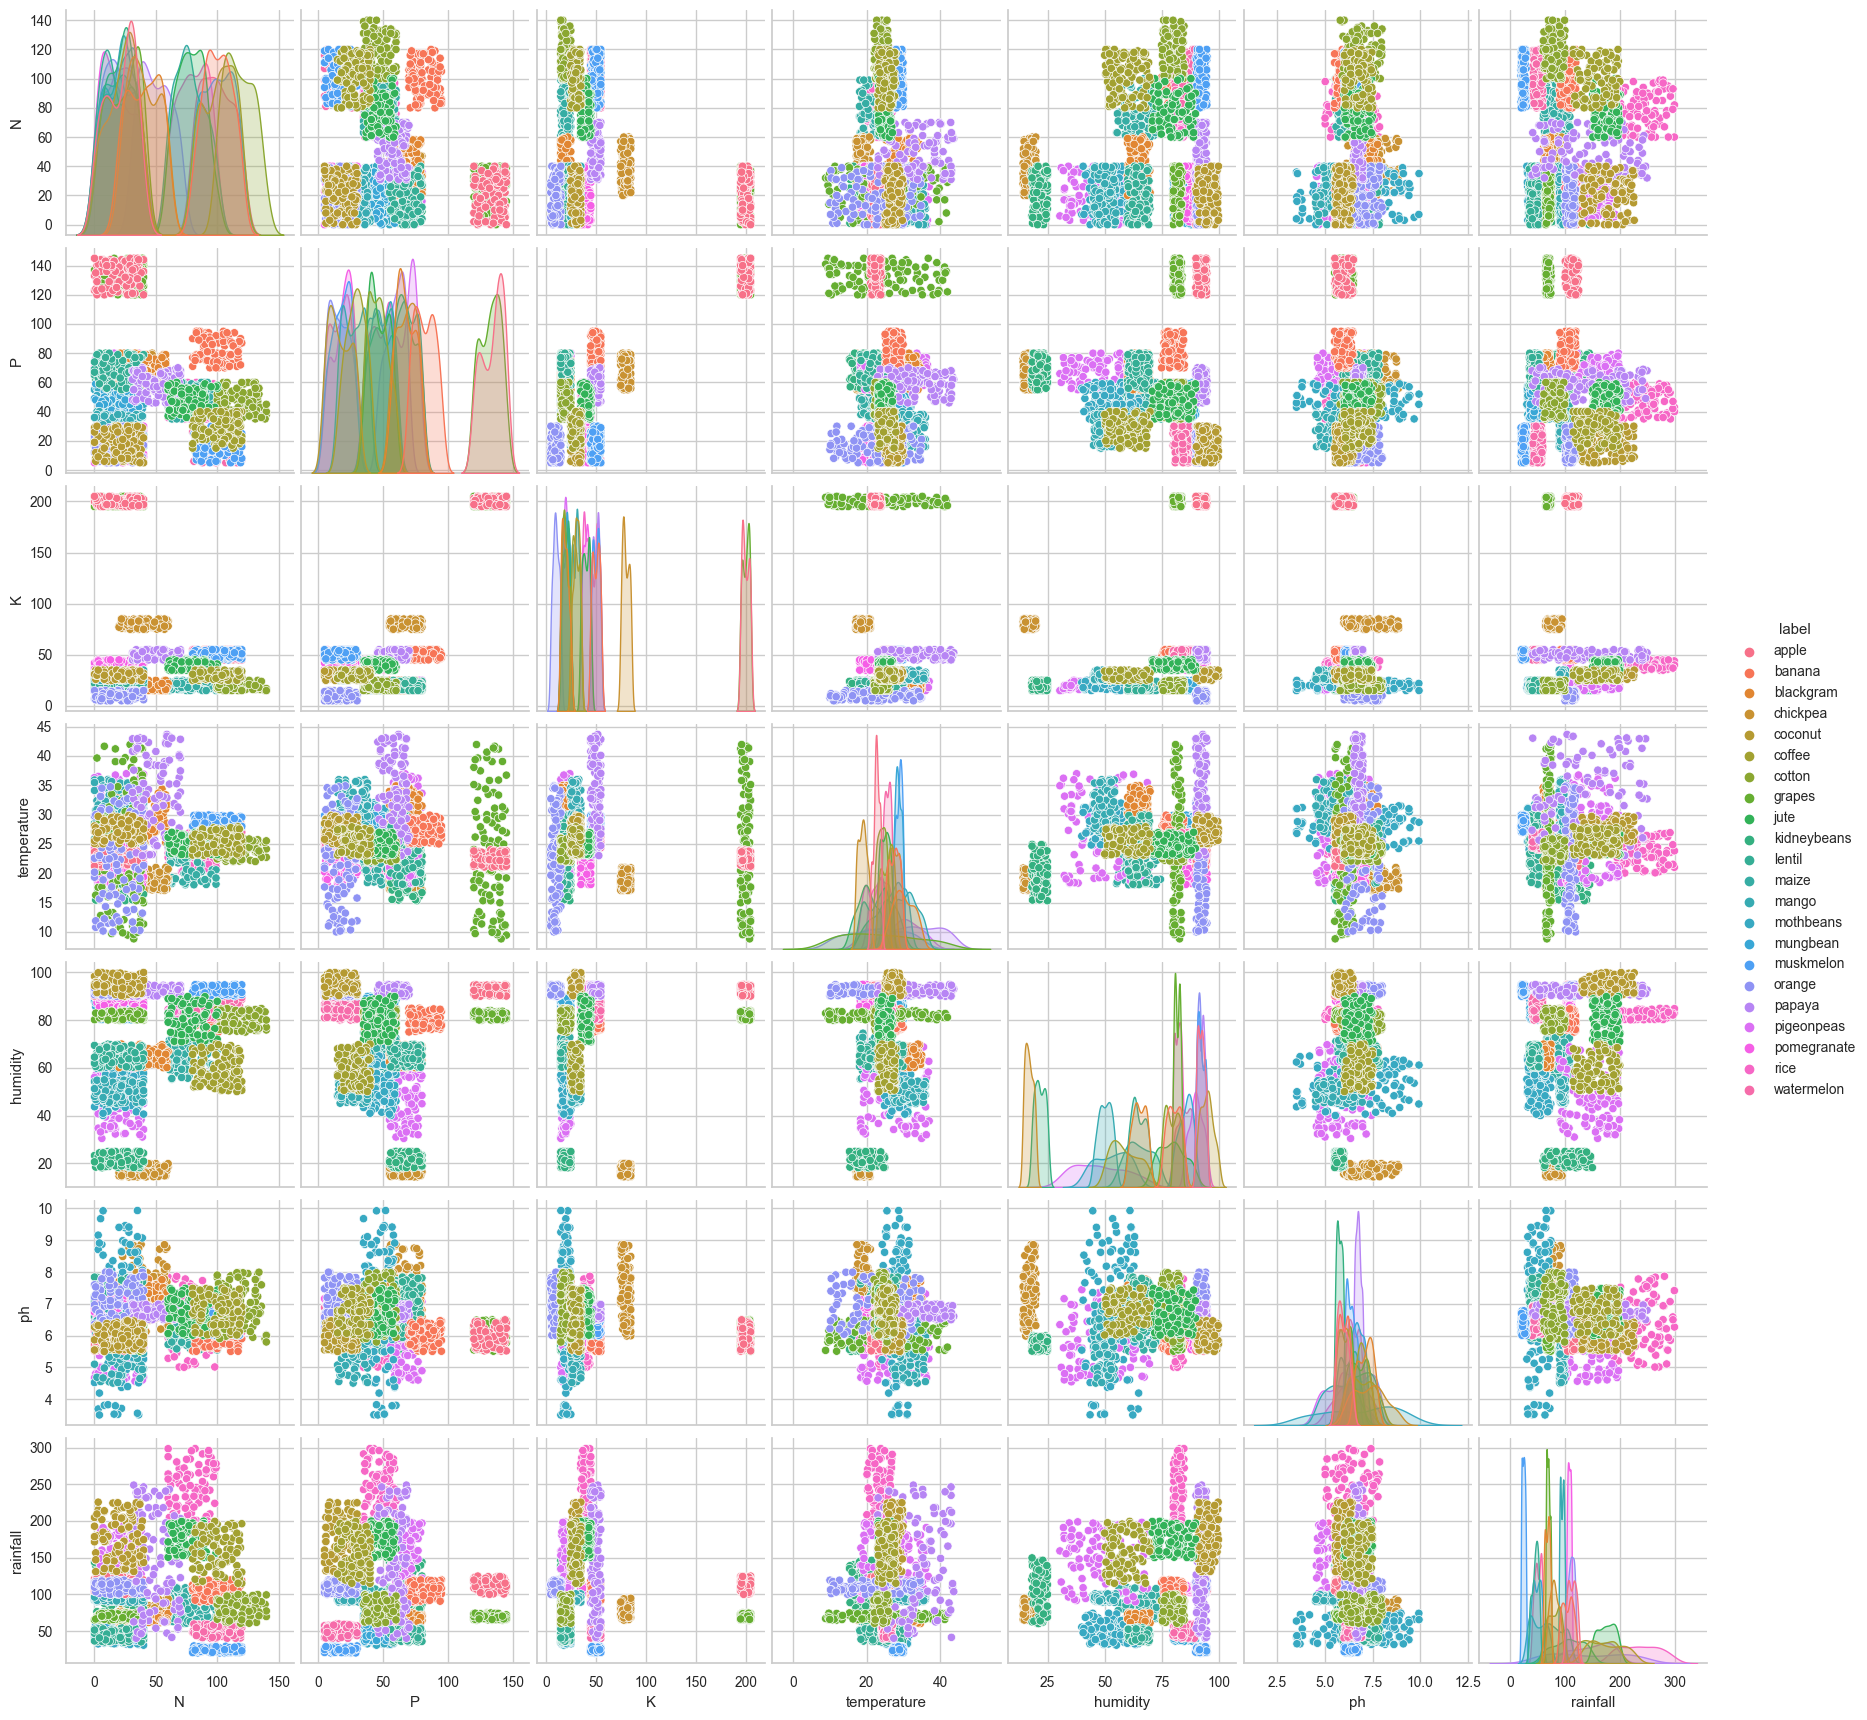

In [ ]:
sns.pairplot(mf, hue = 'label')
plt.show()

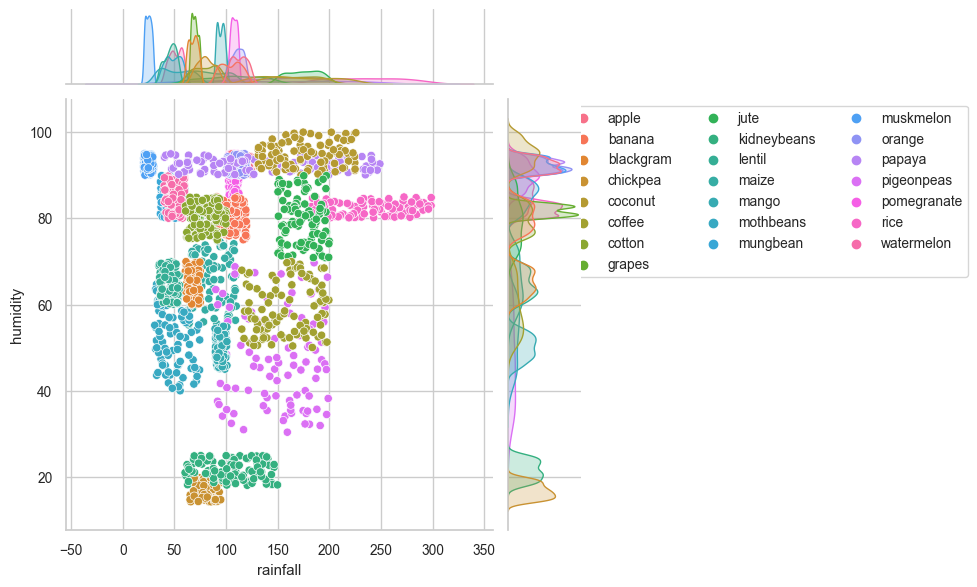

In [221]:
sns.jointplot(x="rainfall", y="humidity", data=mf, hue="label")
plt.legend(bbox_to_anchor=(1.15, 1), ncol=3)
plt.show()

## Classification du type de culture en fonction des donneés du sol et de météo


In [223]:
X = mf.drop('label', axis=1)
y = mf.label.cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

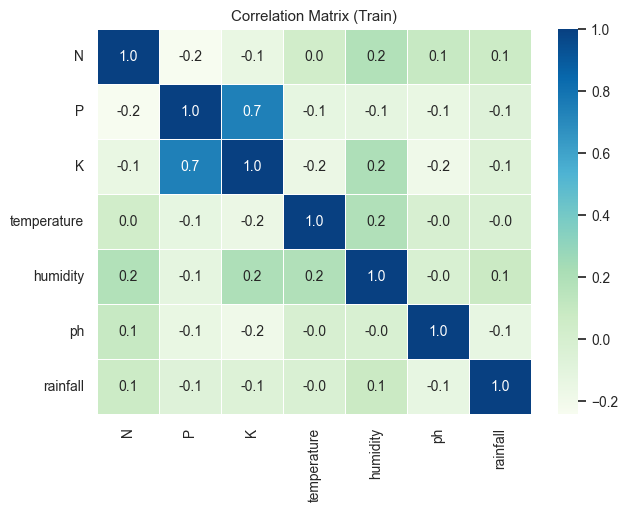

In [224]:
plt.figure(figsize=(7,5))
sns.heatmap(X_train.corr(), annot=True, fmt=".1f", cmap='GnBu', linewidths=.5, annot_kws={"size": 10}).set(title='Correlation Matrix (Train)')
plt.show()

### Recherche du meilleur modèle et de ses paramètres

In [227]:
# environ 2-3 min
estimator_names = ['RandomForestClassifier', 'DecisionTreeClassifier', 'KNeighborsClassifier',
                   'SVC', 'DummyClassifier']

estimator_params = {
    'RandomForestClassifier': {'estimator__max_depth': [4, 6, 8, 10, 12]},
    'SVC' : {'estimator__kernel':  ['poly', 'rbf', 'sigmoid']}
}

res = []
for estimator in estimator_names:
    
    pipeline = Pipeline([
        ('imputer', None),
        ('scaler', None),  #
        ('estimator', eval(estimator)()) 
    ])
    parameters = {
        'scaler': [StandardScaler(), MinMaxScaler(), RobustScaler()],
        'imputer': [SimpleImputer(), IterativeImputer()],
    }
   
    parameters.update(estimator_params.get(estimator, {}))
    
    grid_search = GridSearchCV(pipeline, parameters, cv=5, scoring="accuracy")  
    grid_search.fit(X_train, y_train) 
    cv_results = grid_search.cv_results_
    best_estimator = grid_search.best_estimator_     
    res.append([estimator, grid_search.best_score_, grid_search.best_params_, cv_results, best_estimator]) 
res = pd.DataFrame(res, columns=['Model', 'Best_Score', 'Best_parameters', 'CV_Results', 'Best_estimator'])
#res.to_csv('prediction_rendement_20230707.csv')

Regardons les résultats obtenus

In [229]:
res

Model  Best_Score  \
0  RandomForestClassifier    0.995455   
1  DecisionTreeClassifier    0.986932   
2    KNeighborsClassifier    0.982955   
3                     SVC    0.985795   
4         DummyClassifier    0.050568   

                                     Best_parameters  \
0  {'estimator__max_depth': 12, 'imputer': Simple...   
1  {'imputer': IterativeImputer(), 'scaler': Robu...   
2  {'imputer': SimpleImputer(), 'scaler': RobustS...   
3  {'estimator__kernel': 'poly', 'imputer': Simpl...   
4  {'imputer': SimpleImputer(), 'scaler': Standar...   

                                          CV_Results  \
0  {'mean_fit_time': [0.39069523811340334, 0.3874...   
1  {'mean_fit_time': [0.01474461555480957, 0.0209...   
2  {'mean_fit_time': [0.008177566528320312, 0.006...   
3  {'mean_fit_time': [0.04997062683105469, 0.0228...   
4  {'mean_fit_time': [0.007149028778076172, 0.005...   

                                      Best_estimator  
0  (SimpleImputer(), MinMaxScaler(), (DecisionTre...  
1  (IterativeImputer(), RobustScaler(), DecisionT...  
2  (SimpleImputer(), RobustScaler(), KNeighborsCl...  
3  (SimpleImputer(), MinMaxScaler(), SVC(kernel='...  
4  (SimpleImputer(), StandardScaler(), DummyClass...

À quoi ressemblent les résultats de validation croisée ? 

In [231]:
res['CV_Results'][0]

{'mean_fit_time': array([0.39069524, 0.38749213, 0.36822805, 0.48232551, 0.45730276,
        0.48192916, 0.50803194, 0.41206541, 0.47404528, 0.52122078,
        0.60575948, 0.48106031, 0.71958022, 0.479178  , 0.4286819 ,
        0.62761579, 0.65433121, 0.58077564, 0.42645745, 0.46469378,
        1.30036006, 1.61063976, 1.1306848 , 0.49487181, 0.58155804,
        0.68284926, 0.60897098, 0.8130403 , 0.5527966 , 0.52588859]),
 'std_fit_time': array([0.05914008, 0.06978466, 0.09696141, 0.05847209, 0.06007876,
        0.09487911, 0.09742586, 0.05723255, 0.13054368, 0.07636506,
        0.23512156, 0.08167994, 0.25518152, 0.0927162 , 0.05242479,
        0.11872742, 0.17957676, 0.1170958 , 0.02764072, 0.04514174,
        0.52295663, 0.80554062, 0.2004766 , 0.03428521, 0.10199177,
        0.09679724, 0.07486308, 0.1171678 , 0.04745507, 0.08990932]),
 'mean_score_time': array([0.03019023, 0.02482157, 0.02212973, 0.03272734, 0.03584704,
        0.03766985, 0.02710261, 0.02615662, 0.03253345, 0.03

In [245]:
metric_names = [ "accuracy_score"] # même nom que dans la librairie
metrics = []
for row in res.to_dict('records'):
    model = row['Model']
    time = row['CV_Results']['mean_fit_time'].mean()+row['CV_Results']['mean_score_time'].mean()
    estimator = row['Best_estimator']
    pred_test = estimator.fit(X_train, y_train).predict(X_test)
    m = []
    for metric_name in metric_names:
        m.append(eval(f'{metric_name}(y_test, pred_test)'))
        
    metrics.append([model, time ] + m)
metrics =  pd.DataFrame(metrics, columns=['Model', 'Time']+metric_names)

In [246]:
metrics

Model      Time  accuracy_score
0  RandomForestClassifier  0.650596        0.993182
1  DecisionTreeClassifier  0.028697        0.981818
2    KNeighborsClassifier  0.035068        0.965909
3                     SVC  0.118884        0.963636
4         DummyClassifier  0.016686        0.025000

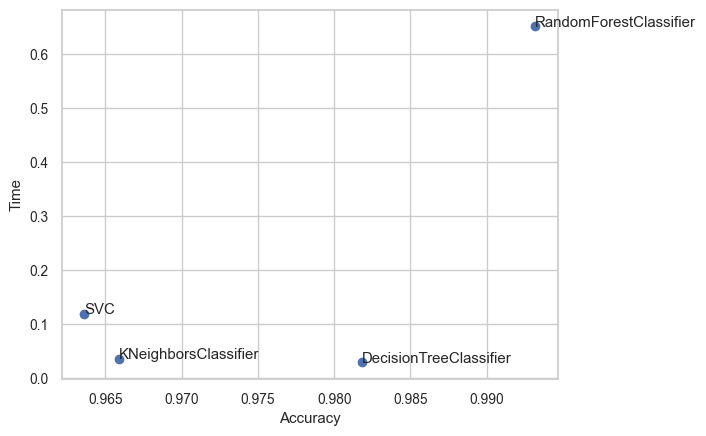

In [248]:
px = metrics.accuracy_score[:-1]
py = metrics.Time[:-1]
plt.scatter(px, py)
for i in range(len(px)):
    plt.text(px[i], py[i], s=metrics.Model[i])
plt.ylabel('Time')
plt.xlabel('Accuracy')
plt.show()

In [251]:
classifier[0]

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('estimator', RandomForestClassifier(max_depth=12))])

In [252]:

classifier = res.loc[res.Model=='RandomForestClassifier', 'Best_estimator'][0]
classifier.fit(X_train, y_train)
test_score = classifier.score(X_test, y_test)
y_pred = classifier.predict(X_test)
print('RandomForestClassifier', round(test_score,2))
print(classification_report(y_test, y_pred, target_names=mf.label.cat.categories))


RandomForestClassifier 0.99
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      0.96      0.94        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14

RandomForestClassifier(max_depth=12)

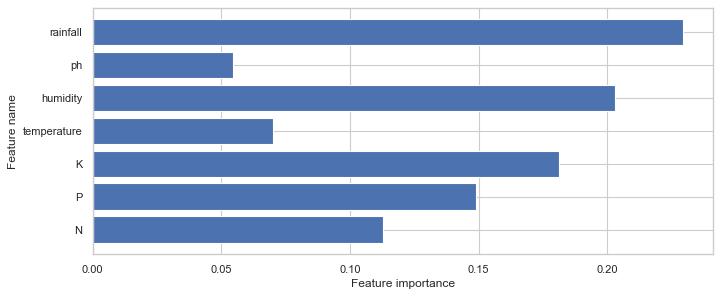

In [259]:
plt.figure(figsize=(10,4), dpi=80)
c_features = len(X_train.columns)
plt.barh(range(c_features), classifier.steps[2][1].feature_importances_)
plt.xlabel("Feature importance")
plt.ylabel("Feature name")
plt.yticks(np.arange(c_features), X_train.columns)
plt.show()


In [260]:
def plot_probabilities_heatmap(X_test, classifier, labels):
    sns.heatmap(classifier.predict_proba(X_test), cmap='viridis', xticklabels=labels, yticklabels=False, cbar=True).set(title='Predicted Probabilities')
    plt.show()
    
def plot_probalities_points(X_test, classifier, labels):
    sns.set(font_scale=0.9, style='whitegrid')
    tmp = pd.DataFrame(classifier.predict_proba(X_test), columns=labels)
    ix = tmp.quantile(0.90, 0).sort_values()
    tmp = tmp.loc[:, ix.index]
    sns.catplot(data=tmp, height=4, aspect=1.6, palette='tab20b').set(title='Predicted Probabilities')
    plt.xticks(rotation=90)
    plt.show()
    
def plot_confusion_matrix(X_test, y_test, classifier, labels):
    mat = confusion_matrix(y_test, classifier.predict(X_test))
    df_cm = pd.DataFrame(mat, list(labels), list(labels))
    sns.set(font_scale=1.0) # for label size
    fig, ax = plt.subplots(figsize=(8,5)) 
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 8}, cmap="terrain", ax=ax).set(title='Confusion Matrix')
    plt.show()
    


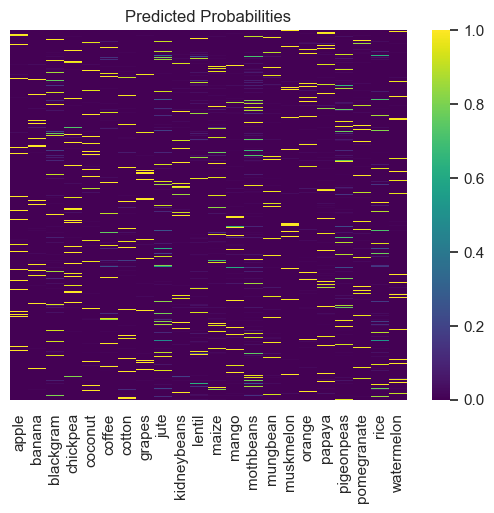

In [265]:
labels = mf.label.cat.categories
plot_probabilities_heatmap(X_test, classifier, labels)

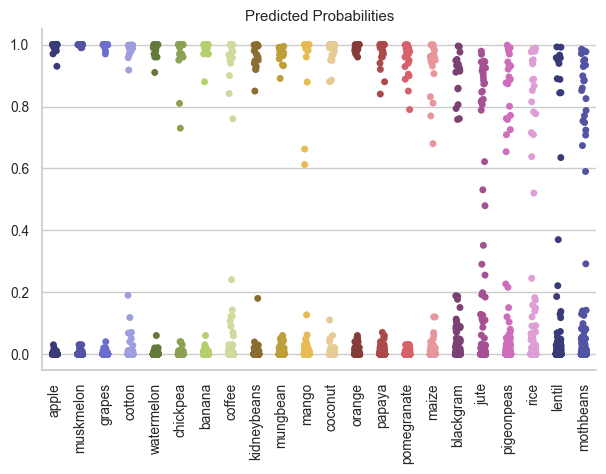

In [263]:
plot_probalities_points(X_test, classifier, labels)

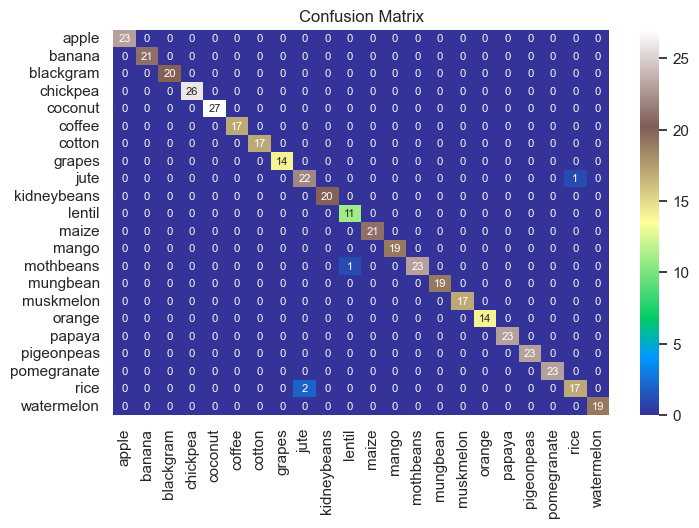

In [264]:
plot_confusion_matrix(X_test, y_test, classifier, labels)

### Other work done with this dataset

* https://www.kaggle.com/code/altafk/real-time-crop-recommendation
* https://www.kaggle.com/code/ysthehurricane/crop-recommendation-system-using-lightgbm
* https://www.kaggle.com/code/atharvaingle/what-crop-to-grow
* https://github.com/the-pinbo/crop-prediction